# Plot the MUA Process

In [1]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, plot_dynamics_2d, plot_dynamics_3d
from matplotlib import colormaps
import pandas as pd
import h5py

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D 

import random

%matplotlib inline

# Get data

In [2]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_laser_rec_time', 'any', 'cue', 'cue_rec_time', 'cue_trial_time', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'single', 'totTime', 'trial_start']>


# Get stim only trials

In [3]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
stim_idxs = stim_idxs[stim_idxs > 150]
stim_idxs

array([151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220,
       221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248,
       249, 250, 251, 252, 253, 254, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289,
       290, 291, 292, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 323, 324, 325, 326, 327, 328, 330, 331, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 34

In [4]:
np.unique(data["pattern_id"][0, stim_idxs])

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29.])

In [5]:
stim_idxs.shape

(269,)

## Get relevant time information

In [6]:
laser_times = data["aligned_laser_rec_time"]
laser_times.shape

(450, 1)

## Get the AP.bin file

In [7]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [8]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [9]:
meta_data = get_meta(meta_path)

In [10]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [11]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [12]:
vmax

0.6

In [13]:
imax

512.0

In [14]:
gain

500.0

In [72]:
float(meta_data['imSampRate'])

30000.0

# Get single trial

In [15]:
bin_size = 1

In [16]:
trial_no = stim_idxs[0]
# get time points in ap space
t = 50
start_time = int((laser_times[trial_no, 0] - t) / 1_000 * 30_000)

# get end of behavior = mouth (260ms) + 300ms 
stim_t = 5
t2 = 50
end_time = int((laser_times[trial_no, 0] + stim_t + t2) / 1_000 * 30_000)

trial = ap_data[:150, start_time:end_time]

conv_data = 1e6 * trial / vmax / imax / gain

filt_data = butter_filter(conv_data, 1_000, 30_000)

c_start = int(laser_times[trial_no, 0] / 1_000 * 30_000)
m_start = c_start - (30 * 2000)
trial_median = ap_data[:150, m_start:c_start]

trial_median = 1e6 * trial_median / vmax / imax / gain
trial_median = butter_filter(trial_median, 1_000, 30_000)

median = np.median(trial_median, axis=1)

spike_ixs, counts = get_spike_events(filt_data, median)

a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

for i, sc in enumerate(spike_ixs):
    a[i, sc] = 1

b = bin_size * 30 # 30ms per bin
binned_spikes = bin_spikes(a, b)

In [17]:
conv_data.shape

(150, 3150)

In [74]:
np.save("/home/clewis/Desktop/trial.npy", trial )

In [76]:
np.load("/home/clewis/Desktop/trial.npy")

array([[24, 27, 19, ..., 27, 25, 28],
       [-2,  1, -4, ...,  3, -5,  2],
       [ 1, -2, -5, ..., -2, -4, -2],
       ...,
       [26, 10,  9, ..., 12,  9, 12],
       [23, 19, 16, ...,  8, 14,  9],
       [42, 35, 28, ..., 19, 27, 31]], shape=(150, 3150), dtype=int16)

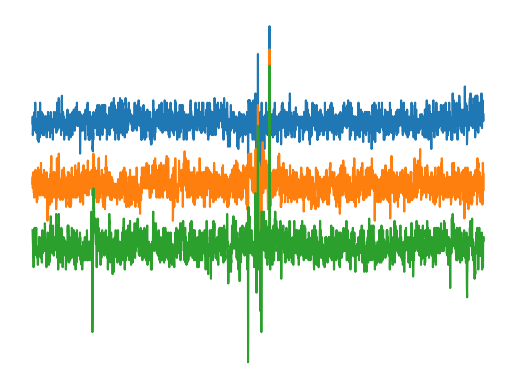

In [25]:
fig, ax = plt.subplots()

ax.plot(conv_data[0])

ax.plot(conv_data[1])

ax.plot(conv_data[2] - 150)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Optionally, remove tick marks if desired for a cleaner look
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.savefig("/home/clewis/Desktop/conv.png")


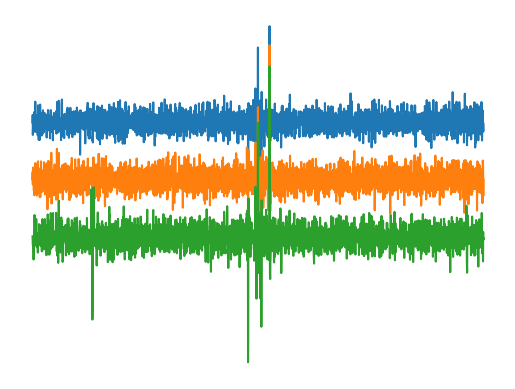

In [28]:
fig, ax = plt.subplots()

ax.plot(filt_data[0] + 150)

ax.plot(filt_data[1])

ax.plot(filt_data[2] - 150)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Optionally, remove tick marks if desired for a cleaner look
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.savefig("/home/clewis/Desktop/filt.png")

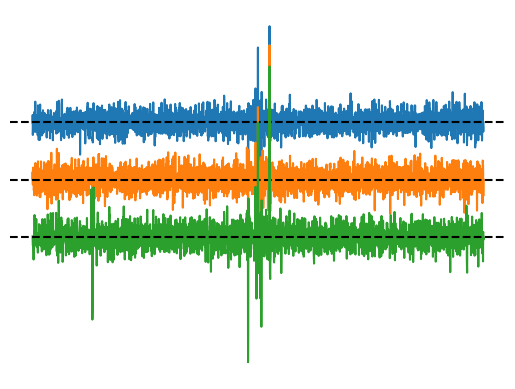

In [32]:
fig, ax = plt.subplots()

ax.plot(filt_data[0] + 150)

ax.axhline(np.median(filt_data[0] + 150, axis=0), linestyle="--", color="black")

ax.plot(filt_data[1])

ax.axhline(np.median(filt_data[1], axis=0), linestyle="--", color="black")

ax.plot(filt_data[2] - 150)
ax.axhline(np.median(filt_data[2] - 150, axis=0), linestyle="--", color="black")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Optionally, remove tick marks if desired for a cleaner look
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.savefig("/home/clewis/Desktop/median.png")

In [35]:
import scipy

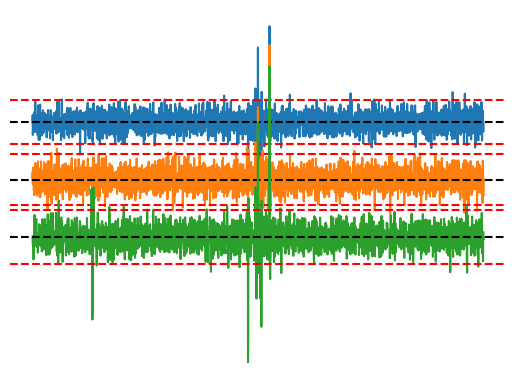

In [53]:
fig, ax = plt.subplots()

ax.plot(filt_data[0])

ax.axhline(np.median(filt_data[0], axis=0), linestyle="--", color="black")

ax.axhline((4 * scipy.stats.median_abs_deviation(filt_data[0])) + np.median(filt_data[0], axis=0), linestyle="--", color="red")

ax.axhline(np.median(filt_data[0], axis=0) - (4 * scipy.stats.median_abs_deviation(filt_data[0])) , linestyle="--", color="red")

# ax.plot(filt_data[1])

ax.plot(filt_data[1] - 150)

ax.axhline(np.median(filt_data[1], axis=0) - 150, linestyle="--", color="black")

ax.axhline((4 * scipy.stats.median_abs_deviation(filt_data[1] - 150)) + np.median(filt_data[1], axis=0) - 150, linestyle="--", color="red")

ax.axhline(np.median(filt_data[1], axis=0) - 150 - (4 * scipy.stats.median_abs_deviation(filt_data[1])) , linestyle="--", color="red")


ax.plot(filt_data[2] - 300)

ax.axhline(np.median(filt_data[2], axis=0) - 300, linestyle="--", color="black")

ax.axhline((4 * scipy.stats.median_abs_deviation(filt_data[2] - 300)) + np.median(filt_data[2], axis=0) - 300, linestyle="--", color="red")

ax.axhline(np.median(filt_data[2], axis=0) - 300 - (4 * scipy.stats.median_abs_deviation(filt_data[2])) , linestyle="--", color="red")

# ax.axhline(np.median(filt_data[1], axis=0), linestyle="--", color="black")

# ax.plot(filt_data[2] - 150)
# ax.axhline(np.median(filt_data[2] - 150, axis=0), linestyle="--", color="black")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Optionally, remove tick marks if desired for a cleaner look
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.savefig("/home/clewis/Desktop/MAD.png")

In [56]:
binned_spikes

array([[0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [2., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(150, 105))

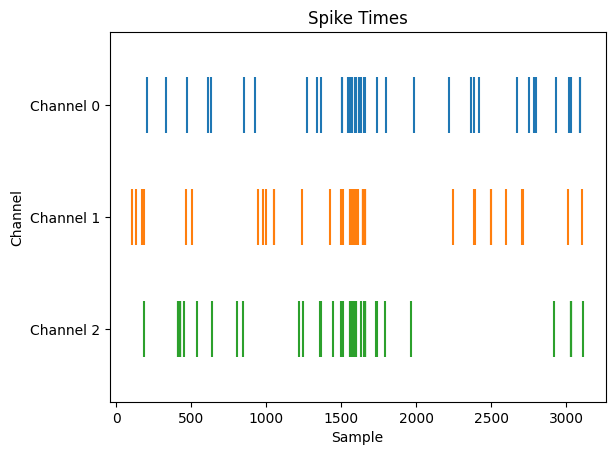

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate some event data
event_times_group1 = np.random.rand(50) * 10  # 50 events between 0 and 10
event_times_group2 = np.random.rand(30) * 10  # 30 events between 0 and 10

# Create the raster plot
plt.eventplot([spike_ixs[2], spike_ixs[1], spike_ixs[0]],
              lineoffsets=[1, 2, 3],  # Offset for each group on the y-axis
              linelengths=0.5,     # Length of the event lines
              colors=['tab:green', 'tab:orange', 'tab:blue'],
              linestyles='-')

plt.xlabel('Sample')
plt.ylabel('Channel')
plt.title('Spike Times')
plt.yticks([1, 2, 3], ['Channel 2', 'Channel 1', "Channel 0"]) # Set custom y-tick labels


plt.savefig("/home/clewis/Desktop/spikes.png")

plt.show()